## Ejecutar las simulaciones


In [56]:
import os

In [57]:
#schedule_names = ['fcfs', 'fcfs-hc', 'fcfs-sa', 'fcfs-sa-opt', 'fcfs-pso', 'sjf', 'sjf-hc', 'sjf-sa', 'sjf-sa-opt', 'sjf-pso', 'easy-backfill', 'easy-backfill-hc', 'easy-backfill-sa', 'easy-backfill-sa-opt', 'easy-backfill-pso']
schedule_names = ['fcfs', 'sjf', 'easy-backfill']
nombres = ','.join(schedule_names)

workload = 'workload.json'
platform = 'small_platform.xml'
#print path actual
base_path = os.path.abspath(os.getcwd())
#remove all before the last '/sched-sim'
base_path = base_path[:base_path.rfind('sched-sim')+len('sched-sim')]
output_folder = 'output_small_platform_w1'
output_folder_results = base_path + '/results'

In [58]:
%%script false --no-raise-error
%%bash -s "$platform" "$workload" "$output_folder" "$nombres"
cd ..
./utils/scripts/run_sim_variables.sh $1 $2 $3 $4

## Imports


In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [60]:
base_path = os.path.abspath(os.getcwd())
#remove all before the last '/sched-sim'
base_path = base_path[:base_path.rfind('sched-sim')+len('sched-sim')]
base_path

'/home/nk/sched-sim'

# Obteniendo los archivos a analizar


In [61]:
schedule_files = []
jobs_files = []
for folders in os.listdir(f'{base_path}/{output_folder}/'):
    for files in os.listdir(f'{base_path}/{output_folder}/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join(f'../{output_folder}', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join(f'../{output_folder}', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output_small_platform_w1/easy-backfill-hc/easy-backfill-hc_schedule.csv', '../output_small_platform_w1/easy-backfill-pso/easy-backfill-pso_schedule.csv', '../output_small_platform_w1/easy-backfill-sa-opt/easy-backfill-sa-opt_schedule.csv', '../output_small_platform_w1/easy-backfill-sa/easy-backfill-sa_schedule.csv', '../output_small_platform_w1/easy-backfill/easy-backfill_schedule.csv', '../output_small_platform_w1/fcfs-hc/fcfs-hc_schedule.csv', '../output_small_platform_w1/fcfs-pso/fcfs-pso_schedule.csv', '../output_small_platform_w1/fcfs-sa-opt/fcfs-sa-opt_schedule.csv', '../output_small_platform_w1/fcfs-sa/fcfs-sa_schedule.csv', '../output_small_platform_w1/fcfs/fcfs_schedule.csv', '../output_small_platform_w1/sjf-hc/sjf-hc_schedule.csv', '../output_small_platform_w1/sjf-pso/sjf-pso_schedule.csv', '../output_small_platform_w1/sjf-sa-opt/sjf-sa-opt_schedule.csv', '../output_small_platform_w1/sjf-sa/sjf-sa_schedule.csv', '../output_small_platform_w1/sjf/sjf_schedule.csv']
['../ou

In [62]:
metrics = pd.DataFrame()
for file in schedule_files:
    print(file)
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[0]
        metrics = metrics.append(df)
    if schedule_name[1] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[1]
        metrics = metrics.append(df)
    print("----")
metrics.set_index('schedule', inplace=True)

../output_small_platform_w1/easy-backfill-hc/easy-backfill-hc_schedule.csv
----
../output_small_platform_w1/easy-backfill-pso/easy-backfill-pso_schedule.csv
----
../output_small_platform_w1/easy-backfill-sa-opt/easy-backfill-sa-opt_schedule.csv
----
../output_small_platform_w1/easy-backfill-sa/easy-backfill-sa_schedule.csv
----
../output_small_platform_w1/easy-backfill/easy-backfill_schedule.csv
----
../output_small_platform_w1/fcfs-hc/fcfs-hc_schedule.csv
----
../output_small_platform_w1/fcfs-pso/fcfs-pso_schedule.csv
----
../output_small_platform_w1/fcfs-sa-opt/fcfs-sa-opt_schedule.csv
----
../output_small_platform_w1/fcfs-sa/fcfs-sa_schedule.csv
----
../output_small_platform_w1/fcfs/fcfs_schedule.csv
----
../output_small_platform_w1/sjf-hc/sjf-hc_schedule.csv
----
../output_small_platform_w1/sjf-pso/sjf-pso_schedule.csv
----
../output_small_platform_w1/sjf-sa-opt/sjf-sa-opt_schedule.csv
----
../output_small_platform_w1/sjf-sa/sjf-sa_schedule.csv
----
../output_small_platform_w1/sjf/

In [63]:
jobsets = {}
for file in jobs_files:
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        print(f"{schedule_name[0]}")
        print("reading", file)
        jobsets[schedule_name[0]] = JobSet.from_csv(file)

easy-backfill
reading ../output_small_platform_w1/easy-backfill/easy-backfill_jobs.csv
fcfs
reading ../output_small_platform_w1/fcfs/fcfs_jobs.csv
sjf
reading ../output_small_platform_w1/sjf/sjf_jobs.csv


In [64]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [65]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [66]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})

In [67]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [68]:
metrics.T

,fcfs,sjf,easy-backfill
batsim_version,4.2.0,4.2.0,4.2.0
consumed_joules,0,0,0
makespan,261070,261168,260984
max_slowdown,67553.6,46457.2,27746.2
max_turnaround_time,15984.5,17841,14783.5
max_waiting_time,15979.5,17830.3,14775.6
mean_slowdown,384.995,354.885,190.013
mean_turnaround_time,1993.14,1920.6,1140.9
mean_waiting_time,1859.85,1787.14,1007.75
nb_computing_machines,4,4,4


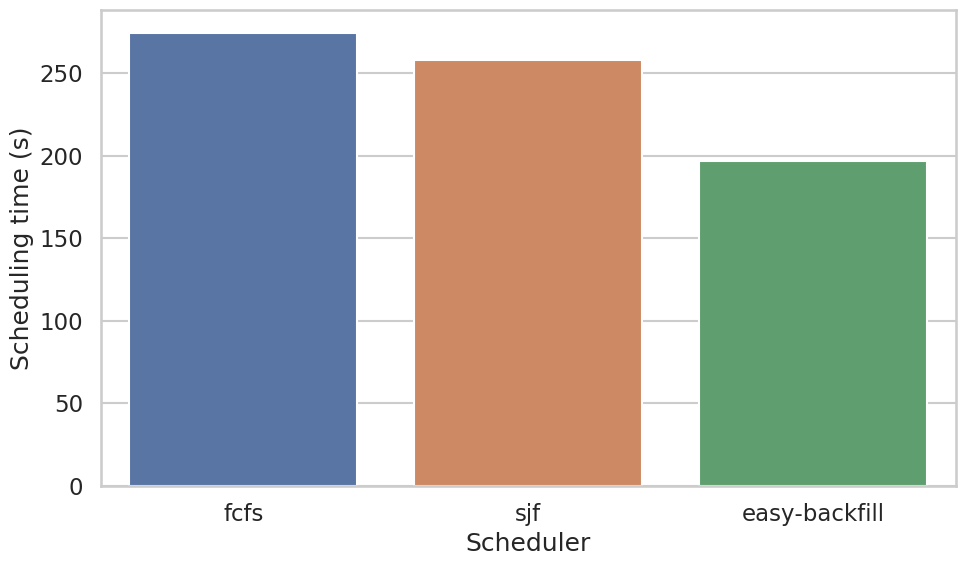

In [69]:
# Scheduling time
sns.set_theme(style='whitegrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=metrics.index, y=metrics.scheduling_time, ax=ax)
ax.set_ylabel('Scheduling time (s)')
ax.set_xlabel('Scheduler')
ax.set_title('Scheduling time')
fig.tight_layout()
path_save = f'{output_folder_results}/scheduling_time.png'
fig.savefig(path_save, bbox_inches='tight')

In [70]:
# Scheduling time comparison table using pandas
metrics.scheduling_time.to_frame().T

,fcfs,sjf,easy-backfill
scheduling_time,274.33362,257.926594,196.854095


In [71]:
import numpy as np
# Scheduling time comparison table using pandas. % performacnce vs others
sched_time = metrics.scheduling_time.to_frame()

# Initialize a matrix to hold the percentage improvement values
improvement_matrix = pd.DataFrame(index=sched_time.index, columns=sched_time.index)

# Calculate percentage improvement for each pair of algorithms
for i in sched_time.index:
    for j in sched_time.index:
        if i != j:
            # Percentage improvement is calculated as: (Value of j - Value of i) / Value of j * 100
            improvement_matrix.loc[i, j] = (sched_time.loc[j, 'scheduling_time'] - sched_time.loc[i, 'scheduling_time']) / sched_time.loc[j, 'scheduling_time'] * 100
        else:
            # No improvement over itself, set to NaN
            improvement_matrix.loc[i, j] = np.nan

improvement_matrix.fillna(0, inplace=True)  # Replacing NaN with 0 for no improvement
improvement_matrix

,fcfs,sjf,easy-backfill
fcfs,0.000000,-6.361122,-39.358859
sjf,5.980684,0.000000,-31.024246
easy-backfill,28.242811,23.678248,0.000000


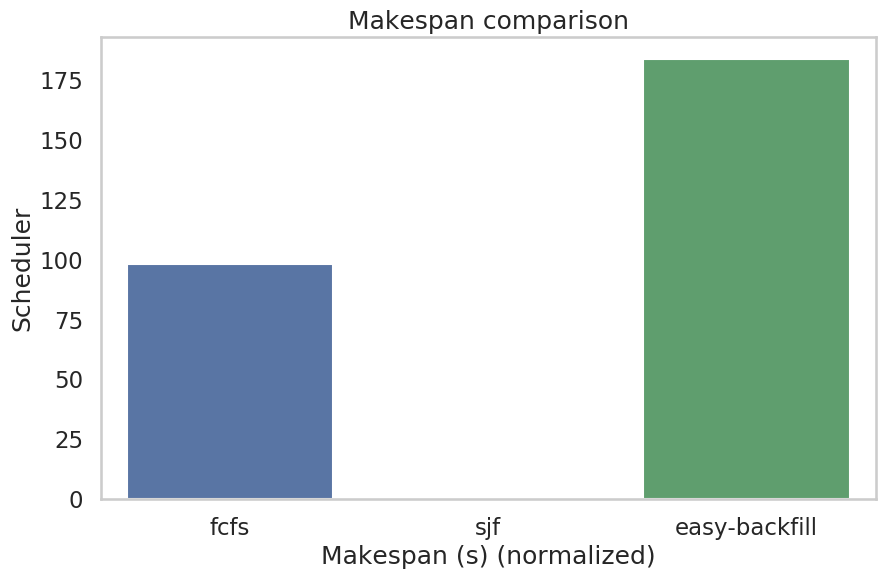

In [72]:
df_metrics = metrics.copy()
df_metrics['makespan'] = abs(df_metrics['makespan'] - df_metrics['makespan'].max())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=df_metrics.index, y=df_metrics.makespan, ax=ax)
ax.set_xlabel('Makespan (s) (normalized)')
ax.set_ylabel('Scheduler')
ax.set_title('Makespan comparison') 
ax.grid(axis='y')
path_save = f'{output_folder_results}/makespan.png'
fig.savefig(path_save, bbox_inches='tight')

In [73]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.000030,19.717915,1.000002
1,fcfs,19.719885,96.082207,1.258241
2,fcfs,96.084178,101.697788,18.116289
3,fcfs,101.699759,120.199439,6.497379
4,fcfs,19.719900,331.307441,1.063288
...,...,...,...,...
2445,easy-backfill,1786.255696,2440.638118,3.729682
2446,easy-backfill,2440.640109,2443.051514,1013.123764
2447,easy-backfill,2443.052991,2454.255854,219.073978
2448,easy-backfill,2454.257331,2466.224970,206.074485


# Waiting Time


In [74]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,sjf,easy-backfill
count,2450.000000,2450.000000,2450.000000
mean,1859.854438,1787.141421,1007.751128
std,2456.555730,2633.121662,1608.219207
min,0.000030,0.000030,0.000030
25%,225.395791,91.465156,30.538780
50%,1042.528974,831.401689,392.430024
75%,2363.795390,2296.503031,1262.565636
max,15979.455910,17830.260609,14775.611934


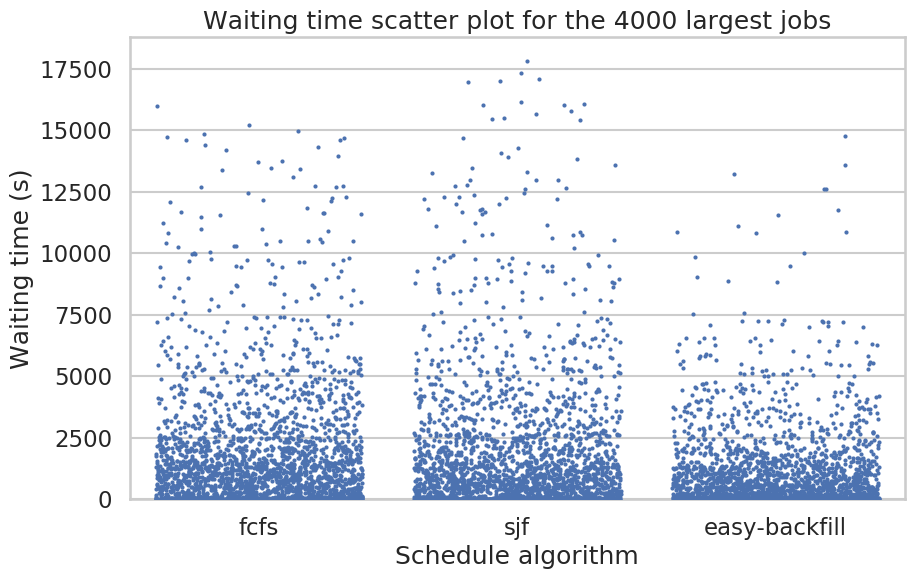

In [75]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('Waiting time (s)')
    ax.set_xlabel('Schedule algorithm')
    ax.set_title('Waiting time scatter plot for the 4000 largest jobs') 
    path_save = f'{output_folder_results}/waiting_time_scatter.png'
    fig.savefig(path_save, bbox_inches='tight')

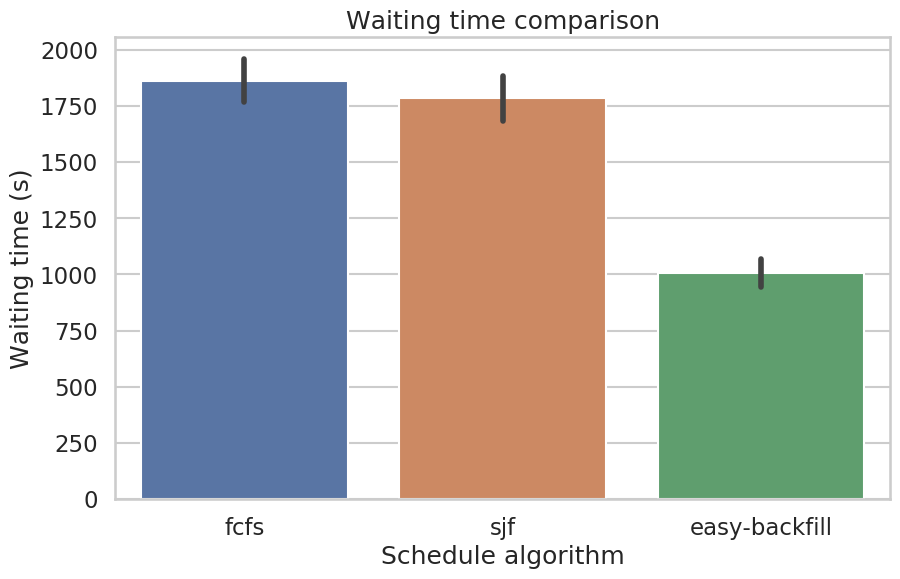

In [76]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=waiting_times, ax=ax)
ax.set_ylabel('Waiting time (s)')
ax.set_xlabel('Schedule algorithm')
ax.set_title('Waiting time comparison') 
path_save = f'{output_folder_results}/waiting_time.png'
fig.savefig(path_save, bbox_inches='tight')

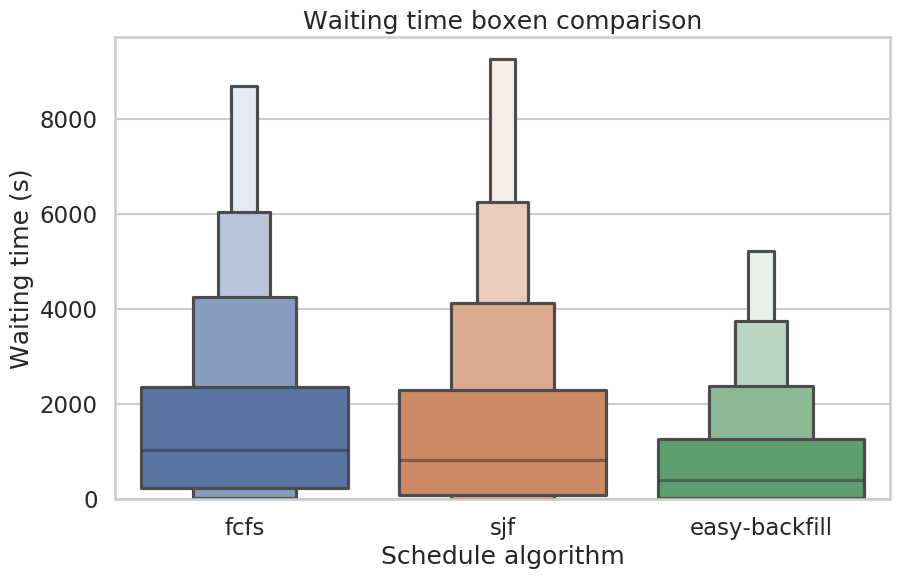

In [77]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
ax.set_ylabel('Waiting time (s)')
ax.set_xlabel('Schedule algorithm')
ax.set_title('Waiting time boxen comparison') 
path_save = f'{output_folder_results}/waiting_time_boxen.png'
fig.savefig(path_save, bbox_inches='tight')

In [78]:
# improve between 2 algorithms, just % in mean of 2 algorithms as input. Example fcfs vs sjf
waiting_times_copy = waiting_times.copy()
improve = -(1 - (waiting_times_copy['sjf'] / waiting_times_copy['fcfs'])) * 100

# Verificar si hay valores infinitos o muy grandes y calcular la media
is_infinite = improve == float('inf')
mean_improve = improve[~is_infinite].mean()

mean_improve, is_infinite.any()

(4451698.824525971, False)

# Turnarround Time


In [79]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,sjf,easy-backfill
count,2450.000000,2450.000000,2450.000000
mean,1993.135829,1920.603502,1140.903382
std,2474.493959,2651.941708,1666.079415
min,0.217383,0.217383,0.217368
25%,368.236092,223.361942,70.964799
50%,1225.993548,992.279873,521.420902
75%,2535.583693,2499.833054,1474.075469
max,15984.460197,17840.972814,14783.485544


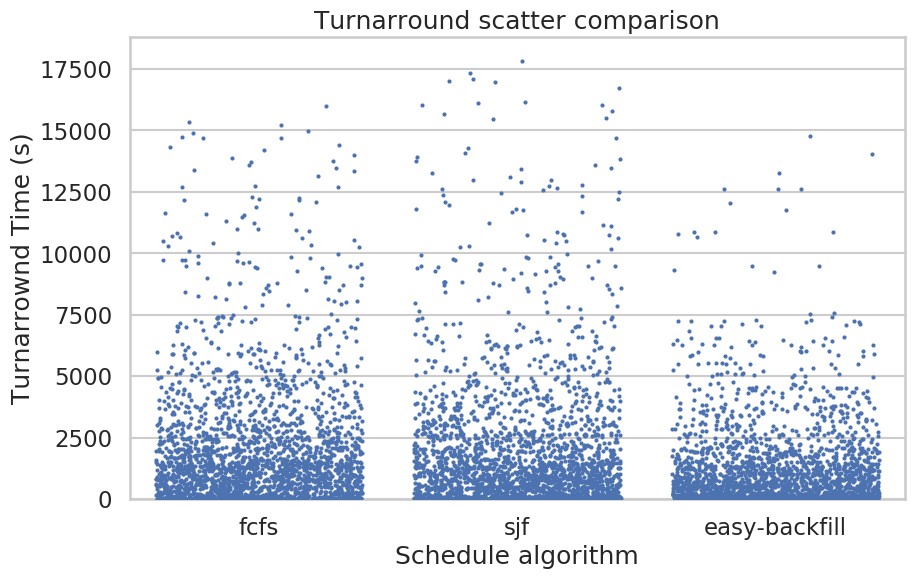

In [80]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)

    ax.set_ylabel('Turnarrownd Time (s)')
    ax.set_xlabel('Schedule algorithm')
    ax.set_title('Turnarround scatter comparison')
    path_save = f'{output_folder_results}/turnaround_time_scatter.png'
    fig.savefig(path_save, bbox_inches='tight')

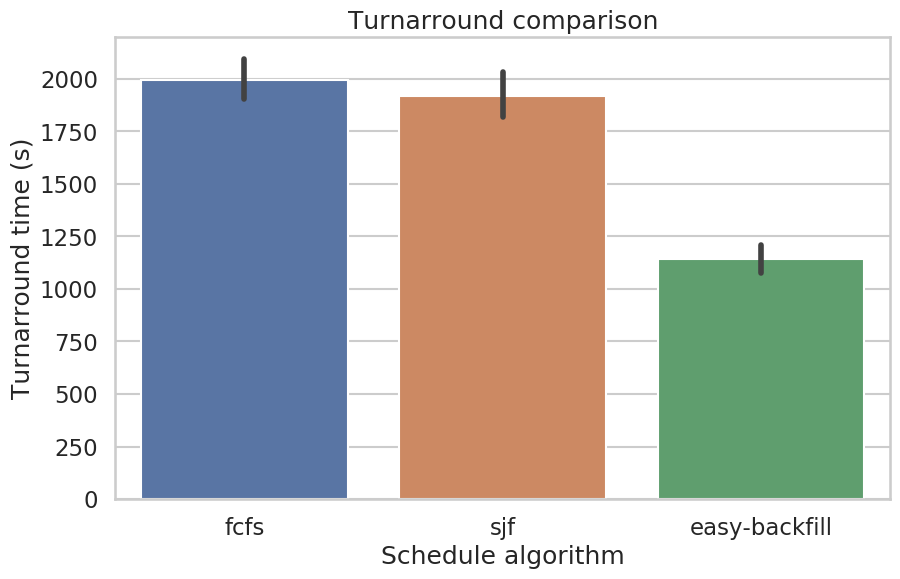

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=turnaround_times, ax=ax)
ax.set_ylabel('Turnarround time (s)')
ax.set_xlabel('Schedule algorithm')
ax.set_title('Turnarround comparison') 
path_save = f'{output_folder_results}/turnarround_time.png'
fig.savefig(path_save, bbox_inches='tight')

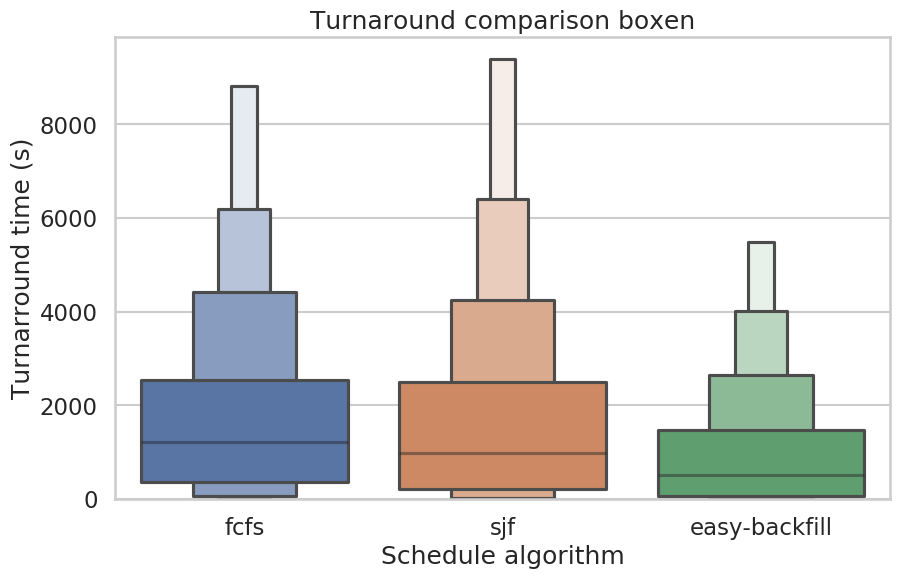

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
ax.set_ylabel('Turnarround time (s)')
ax.set_xlabel('Schedule algorithm')
ax.set_title('Turnaround comparison boxen') 
path_save = f'{output_folder_results}/turnaround_time_boxen.png'
fig.savefig(path_save, bbox_inches='tight')

# Slowdown


In [83]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,sjf,easy-backfill
count,2450.000000,2450.000000,2450.000000
mean,384.995201,354.885370,190.012579
std,2012.460374,1761.091783,1084.798295
min,1.000000,1.000000,1.000000
25%,3.999131,2.709113,2.137837
50%,38.329465,25.929375,9.657220
75%,205.894542,168.433726,75.423721
max,67553.551752,46457.158793,27746.150372


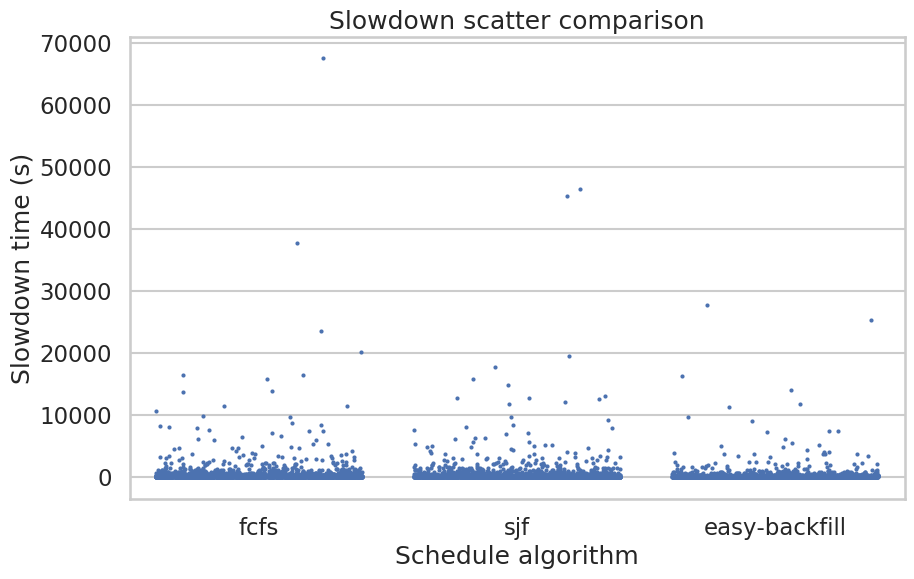

In [84]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylabel('Slowdown time (s)')
    ax.set_xlabel('Schedule algorithm')
    ax.set_title('Slowdown scatter comparison')
    path_save = f'{output_folder_results}/slowdown_scatter.png'
    fig.savefig(path_save, bbox_inches='tight')

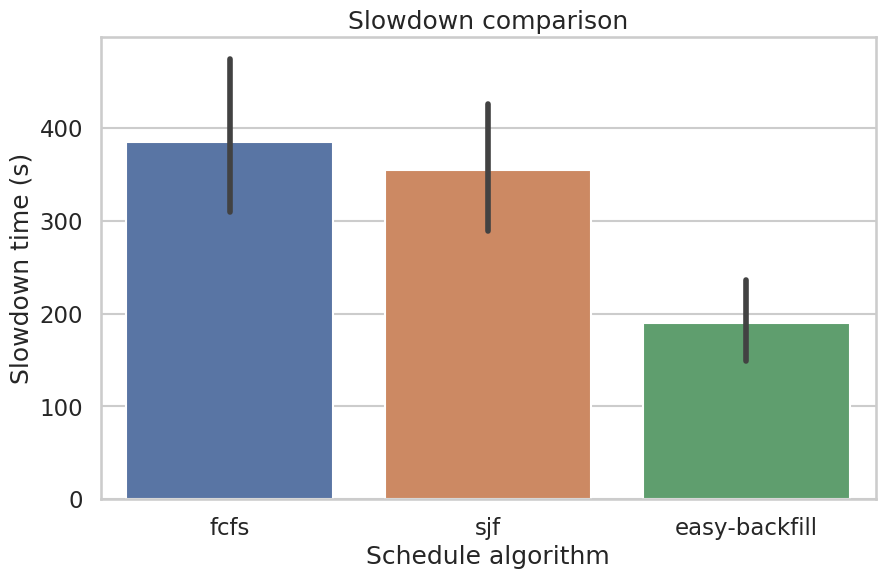

In [85]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=slowdown, ax=ax)
ax.set_ylabel('Slowdown time (s)')
ax.set_xlabel('Schedule algorithm')
ax.set_title('Slowdown comparison') 
path_save = f'{output_folder_results}/slowdown.png'
fig.savefig(path_save, bbox_inches='tight')

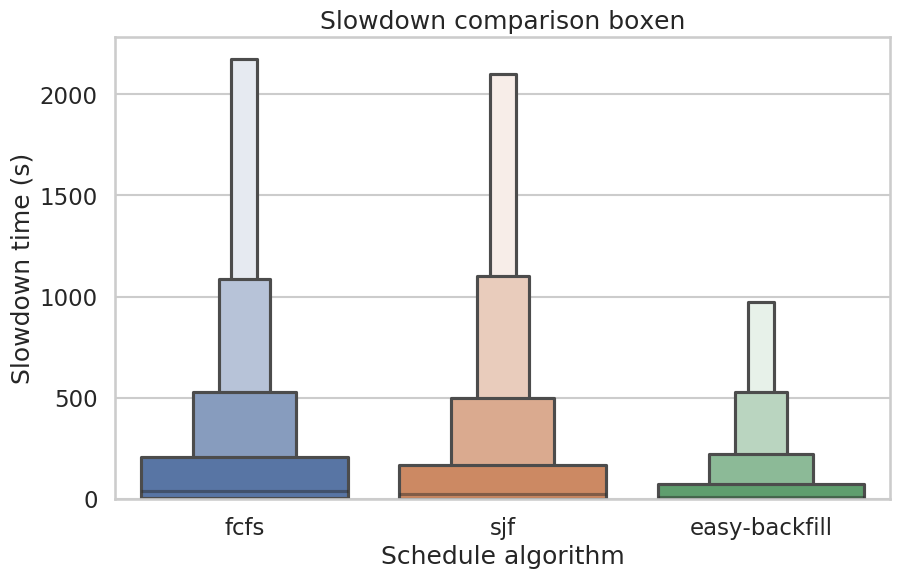

In [86]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
ax.set_ylabel('Slowdown time (s)')
ax.set_xlabel('Schedule algorithm')
ax.set_title('Slowdown comparison boxen') 
path_save = f'{output_folder_results}/slowdown_boxen.png'
fig.savefig(path_save, bbox_inches='tight')

fcfs: 0.025913997141164723
sjf: 0.025921914936084374
easy-backfill: 0.025909850484634473


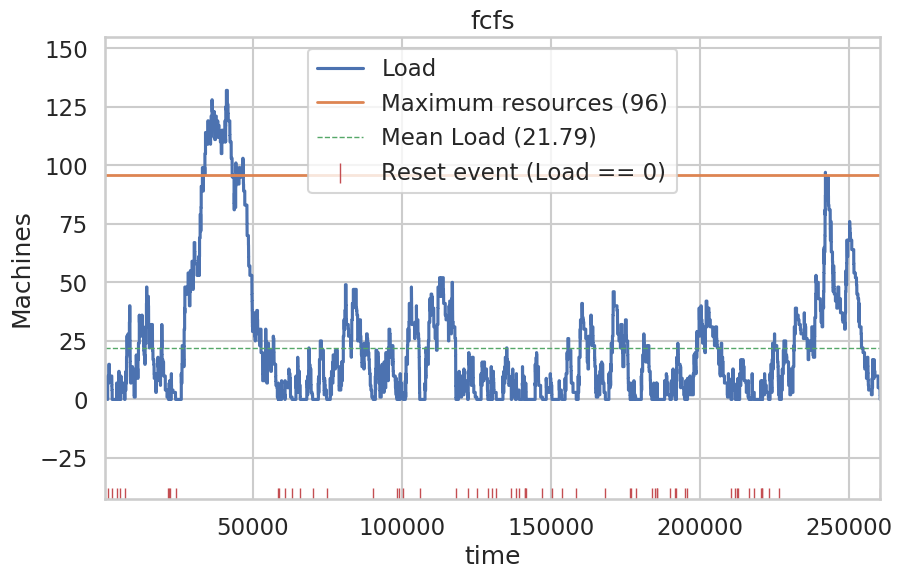

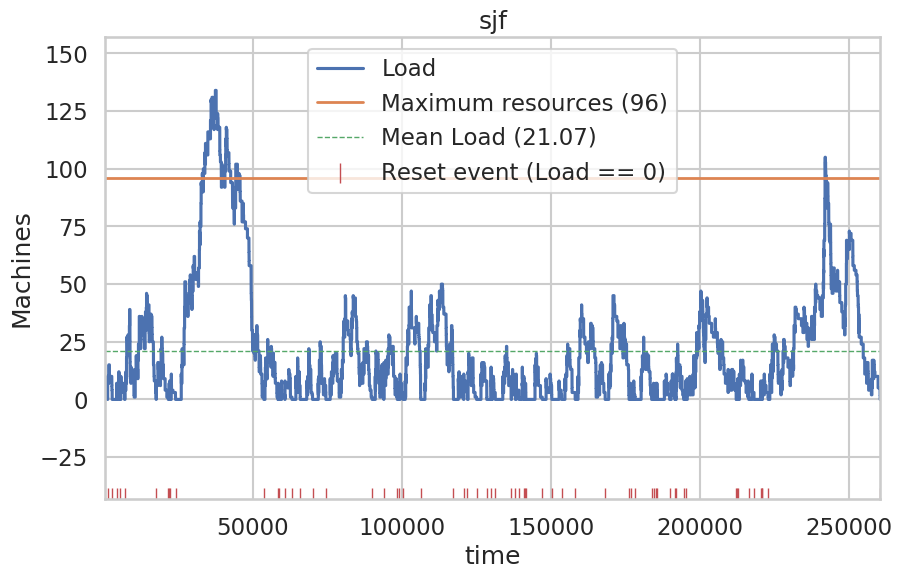

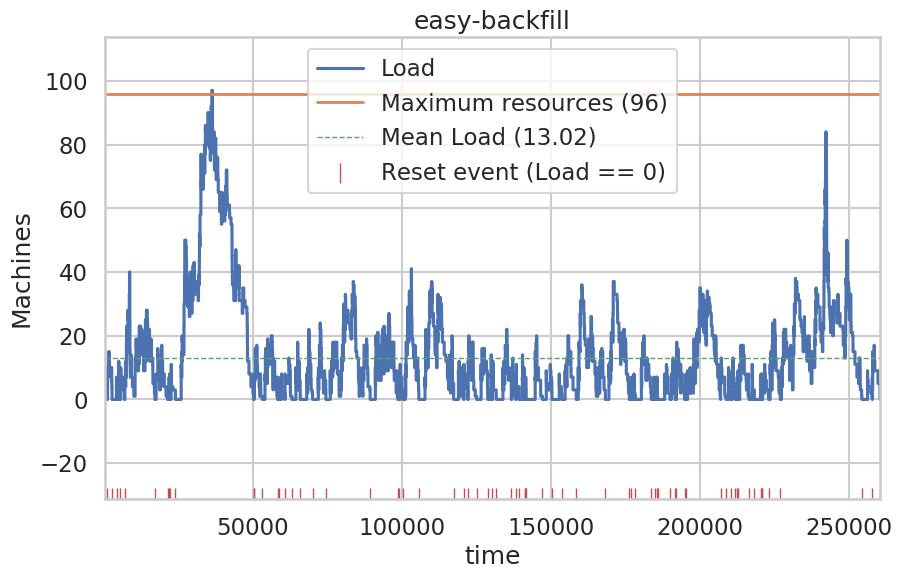

In [87]:
for schedule in schedule_names:
    print(f"{schedule}: {metrics.loc[schedule].compute_utilisation}")
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title(schedule)
    evalys.visu.legacy.plot_load(jobsets[schedule].queue, nb_resources=96, ax=ax)
    path_save = f'{output_folder_results}/{schedule}_load.png'
    fig.savefig(path_save, bbox_inches='tight')

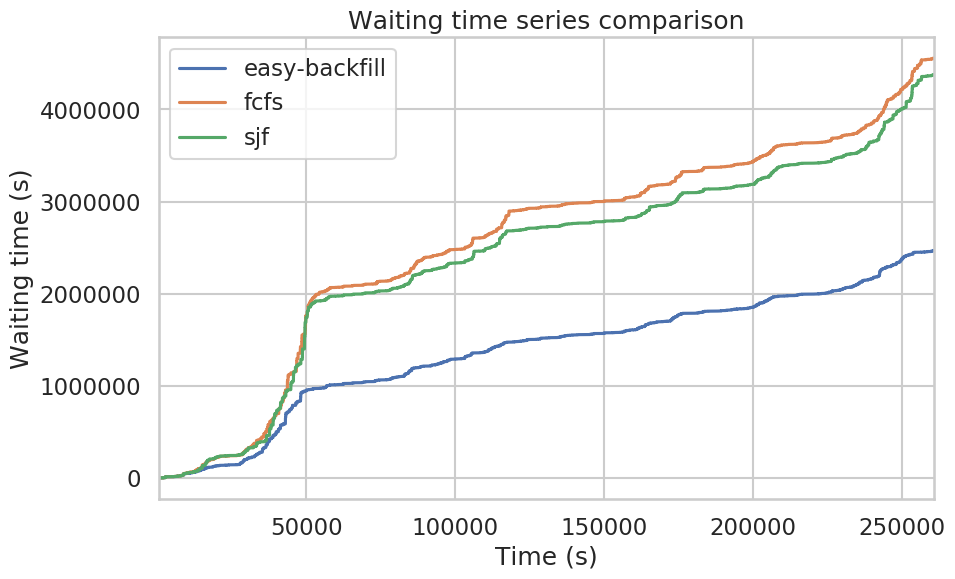

In [88]:
fig, ax = plt.subplots(figsize=(10,6))
evalys.visu.legacy.plot_series('waiting_time', jobsets)
ax.set_ylabel('Waiting time (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Waiting time series comparison')

path_save = f'{output_folder_results}/waiting_time_series.png'
fig.savefig(path_save, bbox_inches='tight')